author: @SteveEckel

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  This example does the boring thing and
checks that everything is working on the $F=0\rightarrow F=1$ transition, which of course
has no sub-Doppler effect.  It is a bit more complicated than the two level molasses example,
as now different kinds of polarizations and $\hat{k}$ vectors can be used.  By exploring 
multiple combinations, we can verify that the OBEs are working properly.

It first checks the force along the $\hat{z}$-direction.  One should look to see that
things agree with what one expects whether or not one puts the detuning on
the lasers or on the Hamilonian.  One should also look at whether the force
depends on transforming the OBEs into the real/imaginary components.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.tools
from scipy.optimize import fsolve
plt.style.use('paper')

### Define the multiple laser beam configurations to start:
Can play with how we divide up the rotating frame a bit.  Answers should
of course be independent (speed may not be)

In [2]:
laser_det = 0.
ham_det = -2.
beta = 1.25

laserBeams = {}
laserBeams['$\\sigma^+\\sigma^+$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams['$\\pi_x\\pi_x$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams['$\\pi_x\\pi_y$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([0., 1., 0.]),
     'pol_coord':'cartesian', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams['$\\sigma^+\\sigma^-$'].total_electric_field_gradient(np.array([0., 0., 0.]), 0.)
magField = lambda R: np.zeros(R.shape)

# Hamiltonian for F=0->F=1
Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
ham_F0_to_F1 = pylcp.hamiltonian(Hg, He - ham_det*np.eye(3), Bgq, Beq, dijq)

### Run a force profile

This checks to see that the rate equations and OBE agree for $F=0\rightarrow F'=1$, two-state solution:

In [3]:
obe={}
rateeq={}

# Define a v axis:
v = np.arange(-5.0, 5.1, 0.125)

for jj, key in enumerate(laserBeams.keys()):
    print('Working on %s:' % key)
    rateeq[key] = pylcp.rateeq(laserBeams[key], magField, ham_F0_to_F1)
    obe[key] = pylcp.obe(laserBeams[key], magField, ham_F0_to_F1,
                         transform_into_re_im=False, include_mag_forces=False)

    # Generate a rateeq model of what's going on:
    rateeq[key].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses'
    )

    obe[key].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True,
    )

Working on $\sigma^+\sigma^+$:
Completed in 11.92 s.                                              
Working on $\sigma^+\sigma^-$:
Completed in 12.34 s.                                              
Working on $\pi_x\pi_x$:
Completed in 13.81 s.                                              
Working on $\pi_x\pi_y$:
Completed in 12.25 s.                                              


Plot 'er up:

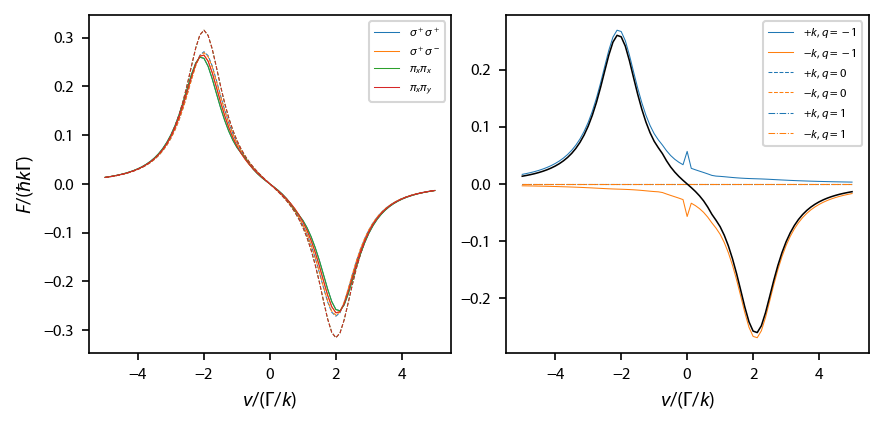

In [4]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
for jj, key in enumerate(laserBeams.keys()):
    ax[0].plot(obe[key].profile['molasses'].V[2],
               obe[key].profile['molasses'].F[2],
               label=key, linewidth=0.5, color='C%d'%jj)
    ax[0].plot(rateeq[key].profile['molasses'].V[2],
               rateeq[key].profile['molasses'].F[2], '--',
               linewidth=0.5, color='C%d'%jj)
ax[0].legend(fontsize=6)
ax[0].set_xlabel('$v/(\Gamma/k)$')
ax[0].set_ylabel('$F/(\hbar k \Gamma)$')

key = '$\\sigma^+\\sigma^+$'
types = ['-', '--', '-.']
for q in range(3):
    ax[1].plot(v, obe[key].profile['molasses'].fq['g->e'][2, :, q, 0], types[q],
            linewidth=0.5, color='C0', label='$+k$, $q=%d$'%(q-1))
    ax[1].plot(v, obe[key].profile['molasses'].fq['g->e'][2, :, q, 1], types[q],
            linewidth=0.5, color='C1', label='$-k$, $q=%d$'%(q-1))
ax[1].plot(v, obe[key].profile['molasses'].F[2], 'k-',
           linewidth=0.75)
ax[1].legend(fontsize=6)
ax[1].set_xlabel('$v/(\Gamma/k)$')
fig.subplots_adjust(wspace=0.15)



### Run a simulation at resonance

This allows us to see what the coherences and such are doing.

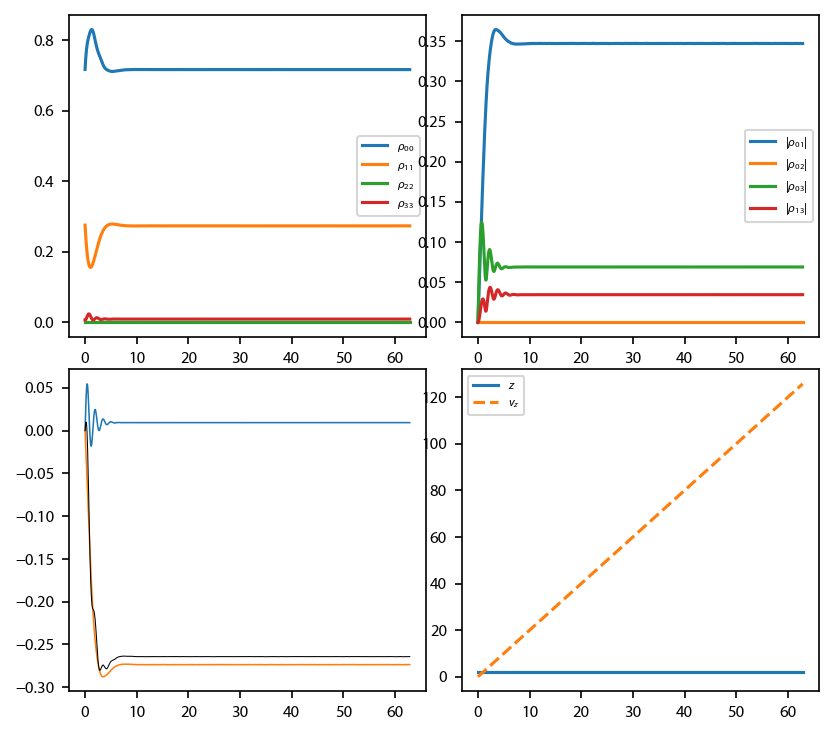

In [5]:
v_i=-(ham_det+laser_det)
key = '$\\sigma^+\\sigma^-$'

obe[key] = pylcp.obe(laserBeams[key], magField, ham_F0_to_F1,
                     transform_into_re_im=True)

obe[key].set_initial_position_and_velocity(
    np.array([0., 0., 0.]), np.array([0., 0., v_i])
    )
rho0 = np.zeros((obe[key].hamiltonian.n**2,), dtype='complex128')
rho0[0] = 1.

if v_i==0 or np.abs(2*np.pi*20/v_i)>500:
    t_max = 500
else:
    t_max = 2*np.pi*20/np.abs(v_i)

obe[key].set_initial_rho_from_rateeq()
obe[key].evolve_density(t_span=[0, t_max], t_eval=np.linspace(0, t_max, 1001),)

f, flaser, flaser_q, f_mag = obe[key].force(obe[key].sol.r, obe[key].sol.t,
                                            obe[key].sol.rho, return_details=True)

fig, ax = plt.subplots(2, 2, num='OBE F=0->F1', figsize=(6.25, 5.5))
ax[0, 0].plot(obe[key].sol.t, np.real(obe[key].sol.rho[0, 0]), label='$\\rho_{00}$')
ax[0, 0].plot(obe[key].sol.t, np.real(obe[key].sol.rho[1, 1]), label='$\\rho_{11}$')
ax[0, 0].plot(obe[key].sol.t, np.real(obe[key].sol.rho[2, 2]), label='$\\rho_{22}$')
ax[0, 0].plot(obe[key].sol.t, np.real(obe[key].sol.rho[3, 3]), label='$\\rho_{33}$')
ax[0, 0].legend(fontsize=6)

ax[0, 1].plot(obe[key].sol.t, np.abs(obe[key].sol.rho[0, 1]), label='$|\\rho_{01}|$')
ax[0, 1].plot(obe[key].sol.t, np.abs(obe[key].sol.rho[0, 2]), label='$|\\rho_{02}|$')
ax[0, 1].plot(obe[key].sol.t, np.abs(obe[key].sol.rho[0, 3]), label='$|\\rho_{03}|$')
ax[0, 1].plot(obe[key].sol.t, np.abs(obe[key].sol.rho[1, 3]), label='$|\\rho_{13}|$')
ax[0, 1].legend(fontsize=6)

ax[1, 0].plot(obe[key].sol.t, flaser['g->e'][2, 0], '-', linewidth=0.75)
ax[1, 0].plot(obe[key].sol.t, flaser['g->e'][2, 1], '-', linewidth=0.75)
ax[1, 0].plot(obe[key].sol.t, f[2], 'k-', linewidth=0.5)

ax[1, 1].plot(obe[key].sol.t, obe[key].sol.v[-1], '-', label='$z$')
ax[1, 1].plot(obe[key].sol.t, obe[key].sol.r[-1], '--', label='$v_z$')
ax[1, 1].legend(fontsize=6)
#ax.plot(v, F_rateeq_F0_to_F1, v, F_obe)

### Finally, let's run with $\vec{k}$ along $\hat{x}$ and $\hat{y}$

Just to make sure that everything is correct.

In [6]:
laserBeams = {}
laserBeams['x'] = {}
laserBeams['x']['$\\sigma^+\\sigma^+$'] = pylcp.laserBeams([
    {'kvec':np.array([ 1., 0., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([-1., 0., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta},
    ])
laserBeams['x']['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([ 1., 0., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    ])
laserBeams['y'] = {}
laserBeams['y']['$\\sigma^+\\sigma^+$'] = pylcp.laserBeams([
    {'kvec':np.array([0.,  1., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta},
    ])
laserBeams['y']['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0.,  1., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., -1., 0.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    ])

obe = {}
rateeq = {}
for coord_key in laserBeams:
    obe[coord_key] = {}
    rateeq[coord_key] = {}
    for pol_key in laserBeams[coord_key]:
        print('Working on %s along %s.' % (pol_key, coord_key))
        rateeq[coord_key][pol_key] = pylcp.rateeq(laserBeams[coord_key][pol_key],
                                                  magField, ham_F0_to_F1)
        obe[coord_key][pol_key] = pylcp.obe(laserBeams[coord_key][pol_key],
                                            magField, ham_F0_to_F1,
                                            transform_into_re_im=False,
                                            include_mag_forces=True)

        if coord_key is 'x':
            V = [v, np.zeros(v.shape), np.zeros(v.shape)]
        elif coord_key is 'y':
            V = [np.zeros(v.shape), v, np.zeros(v.shape)]
        R = np.zeros((3,)+v.shape)
        # Generate a rateeq model of what's going on:
        rateeq[coord_key][pol_key].generate_force_profile(
            R, V, name='molasses'
        )

        obe[coord_key][pol_key].generate_force_profile(
            R, V, name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4,
            itermax=1000, progress_bar=True
        )

Working on $\sigma^+\sigma^+$ along x.
Completed in 19.82 s.                                               
Working on $\sigma^+\sigma^-$ along x.
Completed in 17.77 s.                                               
Working on $\sigma^+\sigma^+$ along y.
Completed in 19.91 s.                                               
Working on $\sigma^+\sigma^-$ along y.
Completed in 17.82 s.                                               


Plot 'er up:

Text(0, 0.5, '$F/(\\hbar k \\Gamma)$')

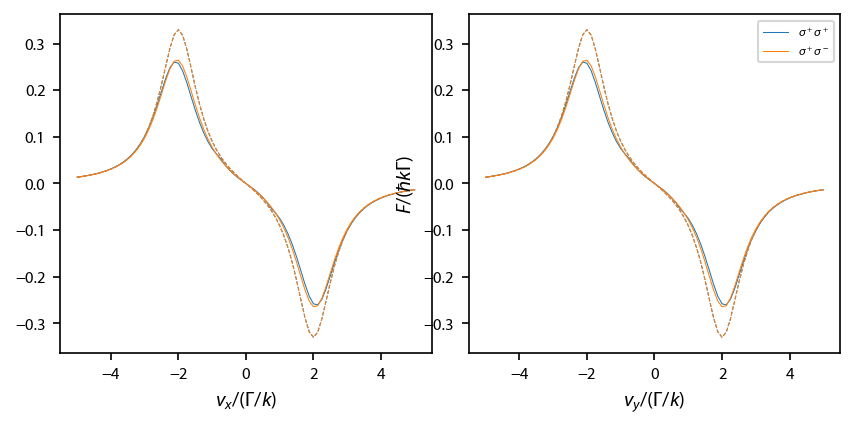

In [7]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
for ii, coord_key in enumerate(laserBeams.keys()):
    for jj, pol_key in enumerate(laserBeams[coord_key].keys()):
        ax[ii].plot(obe[coord_key][pol_key].profile['molasses'].V[ii],
                   obe[coord_key][pol_key].profile['molasses'].F[ii],
                   label=pol_key, linewidth=0.5, color='C%d'%jj)
        ax[ii].plot(rateeq[coord_key][pol_key].profile['molasses'].V[ii],
                    rateeq[coord_key][pol_key].profile['molasses'].F[ii], '--',
                    linewidth=0.5, color='C%d'%jj)
ax[1].legend(fontsize=6)
ax[0].set_xlabel('$v_x/(\Gamma/k)$')
ax[1].set_xlabel('$v_y/(\Gamma/k)$')
ax[1].set_ylabel('$F/(\hbar k \Gamma)$')